In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplleaflet
import geopandas as geopd
import srtm
import gpxpy
import networkx as nx
import process_gpx_data as gpx_process
import os
import shapely


In [2]:
# try and load file
gdf = geopd.read_file('./data/Boulder_Area_Trails.geojson') # 'Trails.geojson')
print("Trails: ", gdf.columns)

gdf_small = geopd.read_file('./data/Trails.geojson')
#print("Trails Dissolved: ", gdf.columns)

Trails:  Index(['OBJECTID', 'TRAILNAME', 'ALIAS', 'LENGTH', 'PEDESTRIAN', 'BIKE',
       'HORSE', 'OHV', 'TRAILTYPE', 'SURTYPE', 'STEWARD', 'DATAOWNER',
       'COMMENTS', 'SHAPESTLength', 'DOGS', 'GlobalID', 'BATTrailID',
       'geometry'],
      dtype='object')


In [5]:
trail_names_full = gdf.TRAILNAME

In [6]:
trail_names_short = gdf_small.FEATURE_NAME

In [7]:
for k in trail_names_full:
    if not k is None:
        if 'Mud' in k or 'mud' in k:
            print(k)

Mud Lake Connector Trail
Mud Lake Access Trail
Mud Lake Access Trail
Nederland Elem. to Mud Lake
Mud Lake to Hwy. 72


In [6]:
gdf.loc[gdf.TRAILNAME=='Mud Lake Connector Trail']

,OBJECTID,TRAILNAME,ALIAS,LENGTH,PEDESTRIAN,BIKE,HORSE,OHV,TRAILTYPE,SURTYPE,STEWARD,DATAOWNER,COMMENTS,SHAPESTLength,DOGS,GlobalID,BATTrailID,geometry
90,91,Mud Lake Connector Trail,None,0.064478,Yes,Yes,Yes,No,Trail,SoftSurface,https://www.bouldercounty.org/open-space/parks...,Boulder County Parks and Open Space,segmented,135.380251,Yes,{1C256E4A-6B85-4221-8C16-9C584F5B5C8E},BCPOS-95,"LINESTRING (-105.51363 39.97616, -105.51352 39..."


In [7]:
gdf_small.loc[0]

OBJECTID                                                   499057
FEATURE_TYPE                                                    3
LOCATION                                                 Mud Lake
FEATURE_NAME                             Mud Lake Connector Trail
SURFACE_TYPE                                              Natural
WIDTH                                                           3
SOURCE                                                        gps
SRC_YEAR                                                     2004
STATUS                                                   existing
OWNER                                                      County
MAINTENANCE                                                County
ENFORCEMENT                                                County
PED                                                           Yes
BIKE                                                          Yes
HORSE                                                         Yes
DOG       

The key columns here are:

    1) SLength = trail length in feet
    
    2) VerticalGain = gain in feet (*need to update with elevation data for consistency*)
    
    3) Z_Min, Z_Max, Z_Mean = min, max, average altitude *see above*
    
    4) Min_Slope, Max_Slope, Avg_Slope = percent grade *see above*
    
    5) geometry = list of coordinates (as LINESTRING object)... 
                  use LINESTRING.coords to get an iterable over the
                  lat long coordinates as tuples. For whatever reason,
                  this appears to be stored as (long, lat)?!?
                  
                

In [3]:
# try and add in elevation data

elevation_data = srtm.get_data()


I can generate elevations from this data using the below dataset (returns elevation in meters!)

In [9]:
# print(elevation_data.get_elevation(temp.coords[0][1], temp.coords[0][0]))

In [10]:
temp = gdf['geometry'][55]

In [11]:
gdf.loc[55]

OBJECTID                                                        56
TRAILNAME                                       Picture Rock Trail
ALIAS                                                             
LENGTH                                                         5.2
PEDESTRIAN                                                     Yes
BIKE                                                           Yes
HORSE                                                          Yes
OHV                                                             No
TRAILTYPE                                                    Trail
SURTYPE                                                SoftSurface
STEWARD          https://www.bouldercounty.org/open-space/parks...
DATAOWNER                      Boulder County Parks and Open Space
COMMENTS                                                 dissolved
SHAPESTLength                                              10964.5
DOGS                                                          

In [9]:

def make_gpx_data(pgdf):
    gpx_data = [None]*len(pgdf)

    for i in np.arange(len(pgdf)):
        gpx_segment = gpxpy.gpx.GPXTrackSegment()    
        try:
            gpx_points = [gpxpy.gpx.GPXTrackPoint(x[1],x[0]) for x in pgdf['geometry'][i].coords]

            gpx_segment.points.extend(gpx_points)
            elevation_data.add_elevations(gpx_segment)

            gpx_data[i] = gpx_segment        
        except:

            # multiple sub-segments
            #   need to stitch these into separate segments
            gpx_data[i] = [None]*len(pgdf['geometry'][i])
            #print(len(gdf['geometry'][i]))

            for seg_i in np.arange(len(pgdf['geometry'][i])):

                gpx_segment = gpxpy.gpx.GPXTrackSegment()
                gpx_segment.points.extend([gpxpy.gpx.GPXTrackPoint(x[1],x[0]) for x in pgdf['geometry'][i][seg_i].coords])
                elevation_data.add_elevations(gpx_segment)

                gpx_data[i][seg_i] = gpx_segment
        
    return gpx_data


Looking at the below, it looks like the distance between any two contiguous GPS points is 9.094 meters

In [13]:
 if False:
    bad_segments_loc = [55, 272, 299, 317, 326, 342, 386, 416, 420, 421, 438]

    max_sub_dist = np.zeros(len(bad_segments_loc))
    min_sub_dist = np.zeros(len(bad_segments_loc))

    for i, iloc in enumerate(bad_segments_loc):



        # get end coords for first segment
        end_lat, end_long = gdf['geometry'].loc[iloc][0].coords[-1][1],\
                            gdf['geometry'].loc[iloc][0].coords[-1][0]

        end_elev = elevation_data.get_elevation(end_lat, end_long)

        sub_dist = np.zeros(len(gdf['geometry'].loc[iloc])-1)

        loop_count = len(gdf['geometry'].loc[iloc])
        for seg_i in np.arange(1, loop_count):

            segment = gdf['geometry'].loc[iloc][seg_i]

            # get the first and last end points of next segment
            start_lat, start_long = segment.coords[0][1], segment.coords[0][0]
            start_elev = elevation_data.get_elevation(start_lat, start_long)

            print(i,seg_i, end_lat, end_long, start_lat, start_long)


            # compute distance
            sub_dist[seg_i-1] = gpxpy.geo.distance(end_lat, end_long, end_elev,
                                             start_lat, start_long, start_elev)


            end_lat, end_long, end_elev = start_lat*1., start_long*1., start_elev*1.


        max_sub_dist[i] = np.max(sub_dist)
        min_sub_dist[i] = np.min(sub_dist)

    #
    # If any of these are below 9.04 we have a problem
    #
    print("Maximums:")
    print(max_sub_dist)
    print(np.min(max_sub_dist))
    print(np.max(max_sub_dist))

    print("Minimums:")
    print(min_sub_dist)
    print(np.min(min_sub_dist))
    print(np.max(min_sub_dist))


In [10]:

def make_plot(pgdf, gpx_data, zoom=True):

    fig, ax = plt.subplots()
    fig.set_size_inches(8,8)

    #m = Basemap(projection='lcc', resolution='h',
     #           width=8.0E4, height=8.0E4, 
     #           lat_0=40.015, lon_0=-105.2705)
    #m.etopo( alpha=0.5)


    for i in np.arange(len(pgdf)):
        if gpx_data[i] is None:
            print(i)
            continue

        elif np.size(gpx_data[i]) == 1:
            data_to_plot = [gpx_data[i]]
        else:
            data_to_plot = gpx_data[i]

        for segment in data_to_plot:
            lats = np.array([x.latitude for x in segment.points])
            longs = np.array([x.longitude for x in segment.points])
            elev = np.array([x.elevation for x in segment.points])
            
            
            ax.plot(longs,lats,lw=5)

    ax.scatter(-105.2705,40.015, color = 'black', s = 200)
    chataqua = (-105.2795, 39.9972)
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 500)


    sep = 0.025
    if zoom:
        ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
        ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
    fig.show()
    
    return fig

<IPython.core.display.Javascript object>


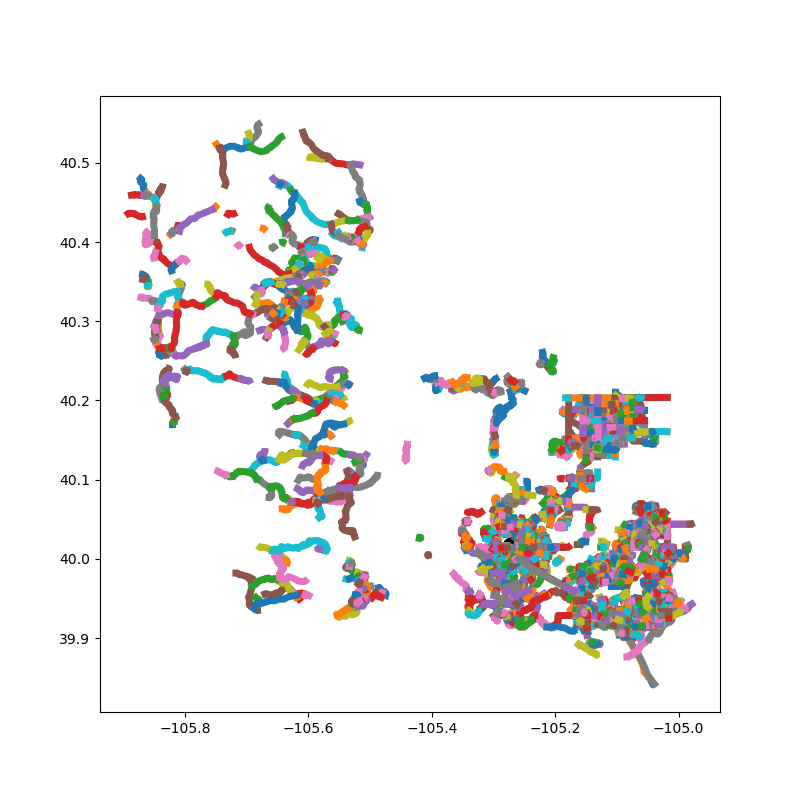

In [11]:
gpx_data = make_gpx_data(gdf)
fig = make_plot(gdf, gpx_data, zoom=False)

In [16]:
#gpx_data_small = make_gpx_data(gdf_small)
#fig = make_plot(gdf_small, gpx_data_small, zoom=False)

In [17]:
gdf.iloc[0]

OBJECTID                                                         1
TRAILNAME                                                AHC Trail
ALIAS                                                             
LENGTH                                                         0.5
PEDESTRIAN                                                     Yes
BIKE                                                            No
HORSE                                                           No
OHV                                                             No
TRAILTYPE                                                    Trail
SURTYPE                                                SoftSurface
STEWARD          https://www.bouldercounty.org/open-space/educa...
DATAOWNER                      Boulder County Parks and Open Space
COMMENTS                                                 dissolved
SHAPESTLength                                              849.297
DOGS                                                          

<IPython.core.display.Javascript object>


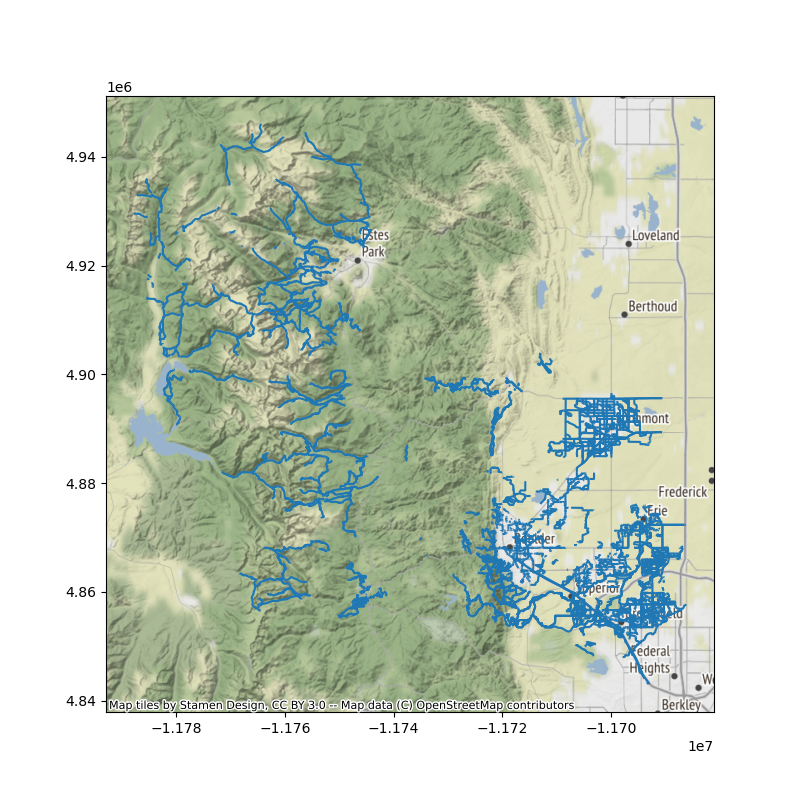

# Lets try a data cleaning algorithm

In [4]:
outname = './data/boulder_area_trail_processed'

remake_data = True

if os.path.isfile(outname + '.geojson') and (not remake_data):
    # reload from file!!!
    new_df, nodes, edges = gpx_process.load_trail_df(outname)
    G                    = gpx_process.load_graph(outname)

else:
    new_df, nodes, edges = gpx_process.process_data(gdf, outname = outname, threshold_distance=8.0)
    G = gpx_process.make_trail_map(new_df, nodes, edges)
    

#
#
#


Computed 22174 nodes for 11087 edges
Modifying Nodes. Creating 6473 new nodes from merging 18286 together
New node list length (10361) from previous (22174)


In [20]:
G

In [21]:
print(elevation_data.get_elevation(G.points[39].latitude, G.points[39].longitude))

AttributeError: 'TrailMap' object has no attribute 'points'

In [ ]:
x = np.array([1,2,3,None])
x == None

In [ ]:
if None in x:
    print('woo')

In [ ]:
[(1,2)] + [x for x in gdf_small.iloc[1]['geometry'].coords] + [(3,4)]

In [ ]:
#for i in range(len(gdf_small)):
#    print(i, x.intersects(gdf_small.iloc[i]['geometry']))

In [ ]:
m_ft = 3.28084
i = 2
for k in ['Z_Min','Z_Max','Z_Mean','SLength']:
    print(k, gdf_small.iloc[i][k] / m_ft)
print('------------------------------------------')
for k in ['max_altitude','min_altitude','distance']:
    print(k, new_df.iloc[i][k])

In [22]:
def plot(graph, node_order=None,
         weight='distance',
         region = None):
    
    #pos = nx.spring_layout(graph, weight=weight, seed = 12345)
    
    
    pos = {ni : np.array([n['long'],n['lat']]) for ni,n in graph.nodes(data=True)}
    
    pc = nx.draw_networkx_nodes(graph, pos, node_size=20)
    ax = pc.figure.axes[0]

    pc.figure.set_size_inches(8,8)

    #edges = [(u,v)]
    #etraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] > 0]
    #enottraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] == 0]

    colors = 'black'
    #if not (node_order is None):
    #    ecolor_int = [node_order.index(e[0]) for e in etraveled]
    #    colors = magma((np.array(ecolor_int)+5) / ((1.0*len(node_order)+5)))
        
    temp = nx.draw_networkx_edges(graph, pos, edgelist=graph.edges, width=2, edge_color=colors)
    #temp = nx.draw_networkx_edges(graph, pos, edgelist=enottraveled, width=2, style='dashed')
    
    #try:
    #    edge_labels = { (u,v) : "%i"%(d['ShapeLen']) for (u,v,d) in graph.edges(data=True)}
    #except:    
    #    edge_labels = { (u,v) : "%i"%(d['SHAPESTLength']) for (u,v,d) in graph.edges(data=True)}
    #temp = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.5)
    
    #temp = nx.draw_networkx_labels(graph, pos, labels={n:n for n,data in graph.nodes(data=True)}, font_size=17,
    #                        font_color = 'black')
    
    
    chataqua = (-105.2795, 39.9972)
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 200)


    #sep = 0.025
    #if zoom:
    #    ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
    #    ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
        
    #print(pos)
    return pc,ax

<IPython.core.display.Javascript object>


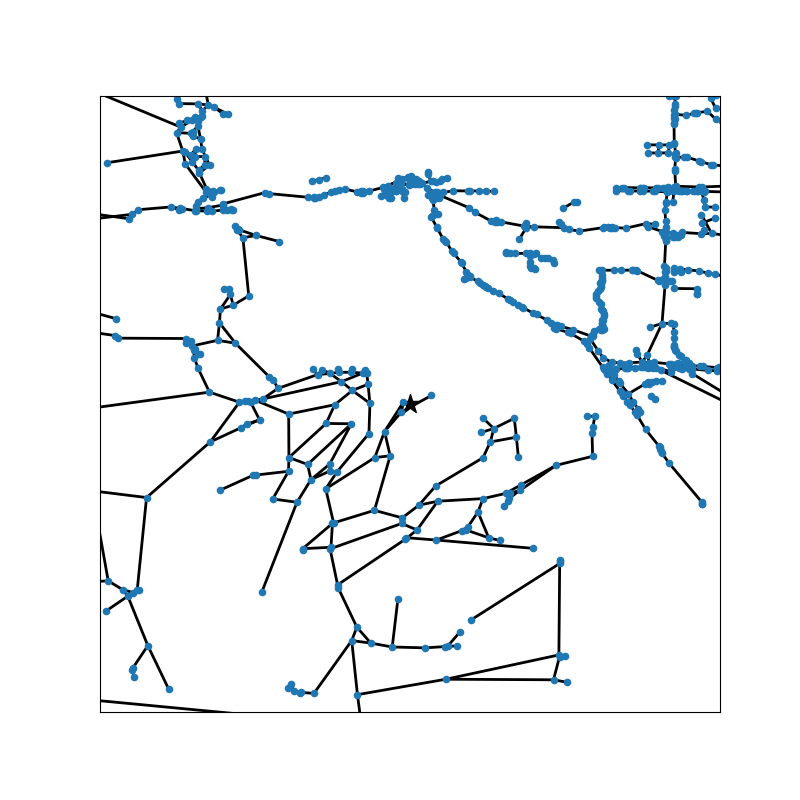

(-105.3045, -105.2545)

In [23]:
%matplotlib notebook

pc,ax = plot(G)
#ax.set_xlim()
pc.figure.show()


chataqua = (-105.2795, 39.9972)
sep = 0.025
ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)

#plt.show()

<IPython.core.display.Javascript object>


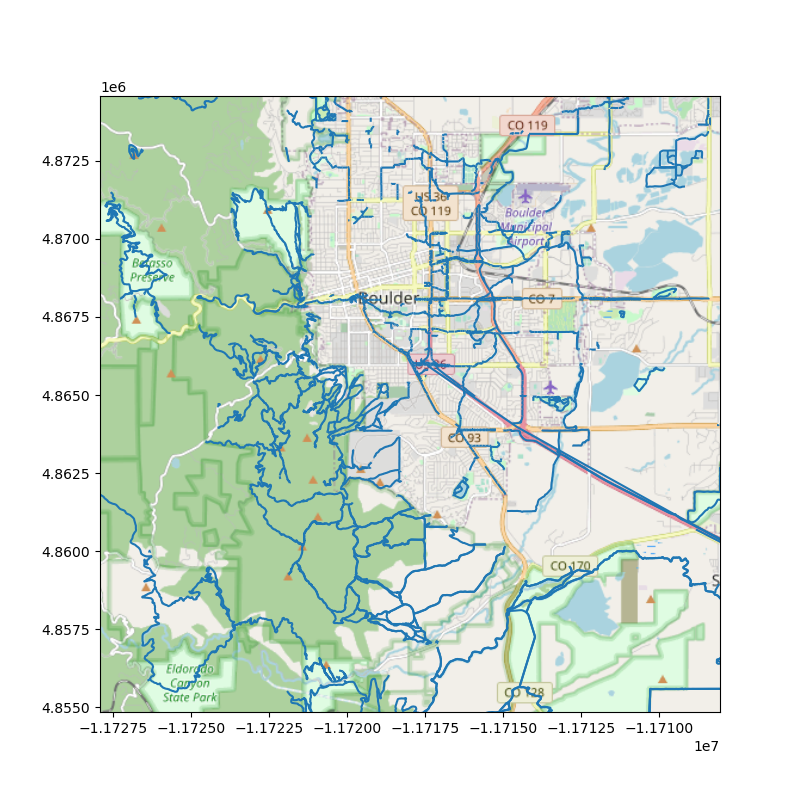

/home/aemerick/anaconda3/envs/planit/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  
/home/aemerick/anaconda3/envs/planit/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  


In [15]:
#%matplotlib widget
import contextily as ctx
gdf_crs = new_df.copy().to_crs(epsg=3857)
ax = gdf_crs.plot()
ax.figure.set_size_inches(8,8)
ctx.add_basemap(ax, url = ctx.tile_providers.OSM_A, zoom=12)
ax.figure.show()


In [19]:
plt.savefig('test_map2.png')

In [ ]:

for i in range(len(df)):
    phenomes = df['phenomes'] # assuming this gives a list or array
    
    for p in phenomes: 
        gdf_small.at[i,p] = 1